In [1]:

##########################################################################################
##########################################################################################

# Set up the environment

import sys

# Add path for python to look into for modules installed using pip

sys.path.append('/usr/local/lib/python3.7/site-packages/')

import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
import datetime

# Set seaborn options

# sns.set(style = 'darkgrid', context = 'talk', palette = 'Dark2')

# Set global matplotlib options (https://matplotlib.org/tutorials/introductory/customizing.html)

matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['figure.dpi'] = 240
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'
matplotlib.rcParams['legend.fontsize'] = 'large'

# matplotlib.rcParams.keys()

##########################################################################################
##########################################################################################

# Change into the correct directory

if os.getcwd() != os.path.expanduser('~') + '/finpy/':
    os.chdir(os.path.expanduser('~') + '/finpy/')
else:
    pass

##########################################################################################

# RMSE function

def RMSE(observations, predictions):
    return np.sqrt(((predictions - observations) ** 2).mean())

##########################################################################################

# Set prediction period (in days)

pred_period = 30

# Define the variable of interest

target_stock = 'MSFT'

target = target_stock + '_adjusted_close'

##########################################################################################

###################
##### READ THE DATA
###################

data = pd.read_csv('data/filt_data.csv', sep=',', index_col=0)

train = pd.read_csv('data/train.csv', sep=',', index_col=0)

test = pd.read_csv('data/test.csv', sep=',', index_col=0)

# Split data

x_train = train[[c for c in train.columns if c != 'price']] # features

y_train = train['price'] # observations

x_test = test[[c for c in test.columns if c != 'price']] # features

y_test = test['price'] # observations

In [2]:
###########################
##### POLYNOMIAL REGRESSION
###########################

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Set the degree of the polynomial

d = 2

# Transform data

x_train_trans = PolynomialFeatures(degree=d, include_bias=False).fit_transform(x_train)

x_test_trans = PolynomialFeatures(degree=d, include_bias=False).fit_transform(x_test)
    
# Create a model and fit it

print('Running Multivariate Polynomial Regression of Degree:', d)

poly = LinearRegression().fit(x_train_trans, y_train)
    
y_pred = poly.predict(x_test_trans)

# Calculate the RMSE

rmse = RMSE(observations=y_test, predictions=y_pred)

print('RMSE:', rmse)

Running Multivariate Polynomial Regression of Degree: 2
RMSE: 106.00346414215902


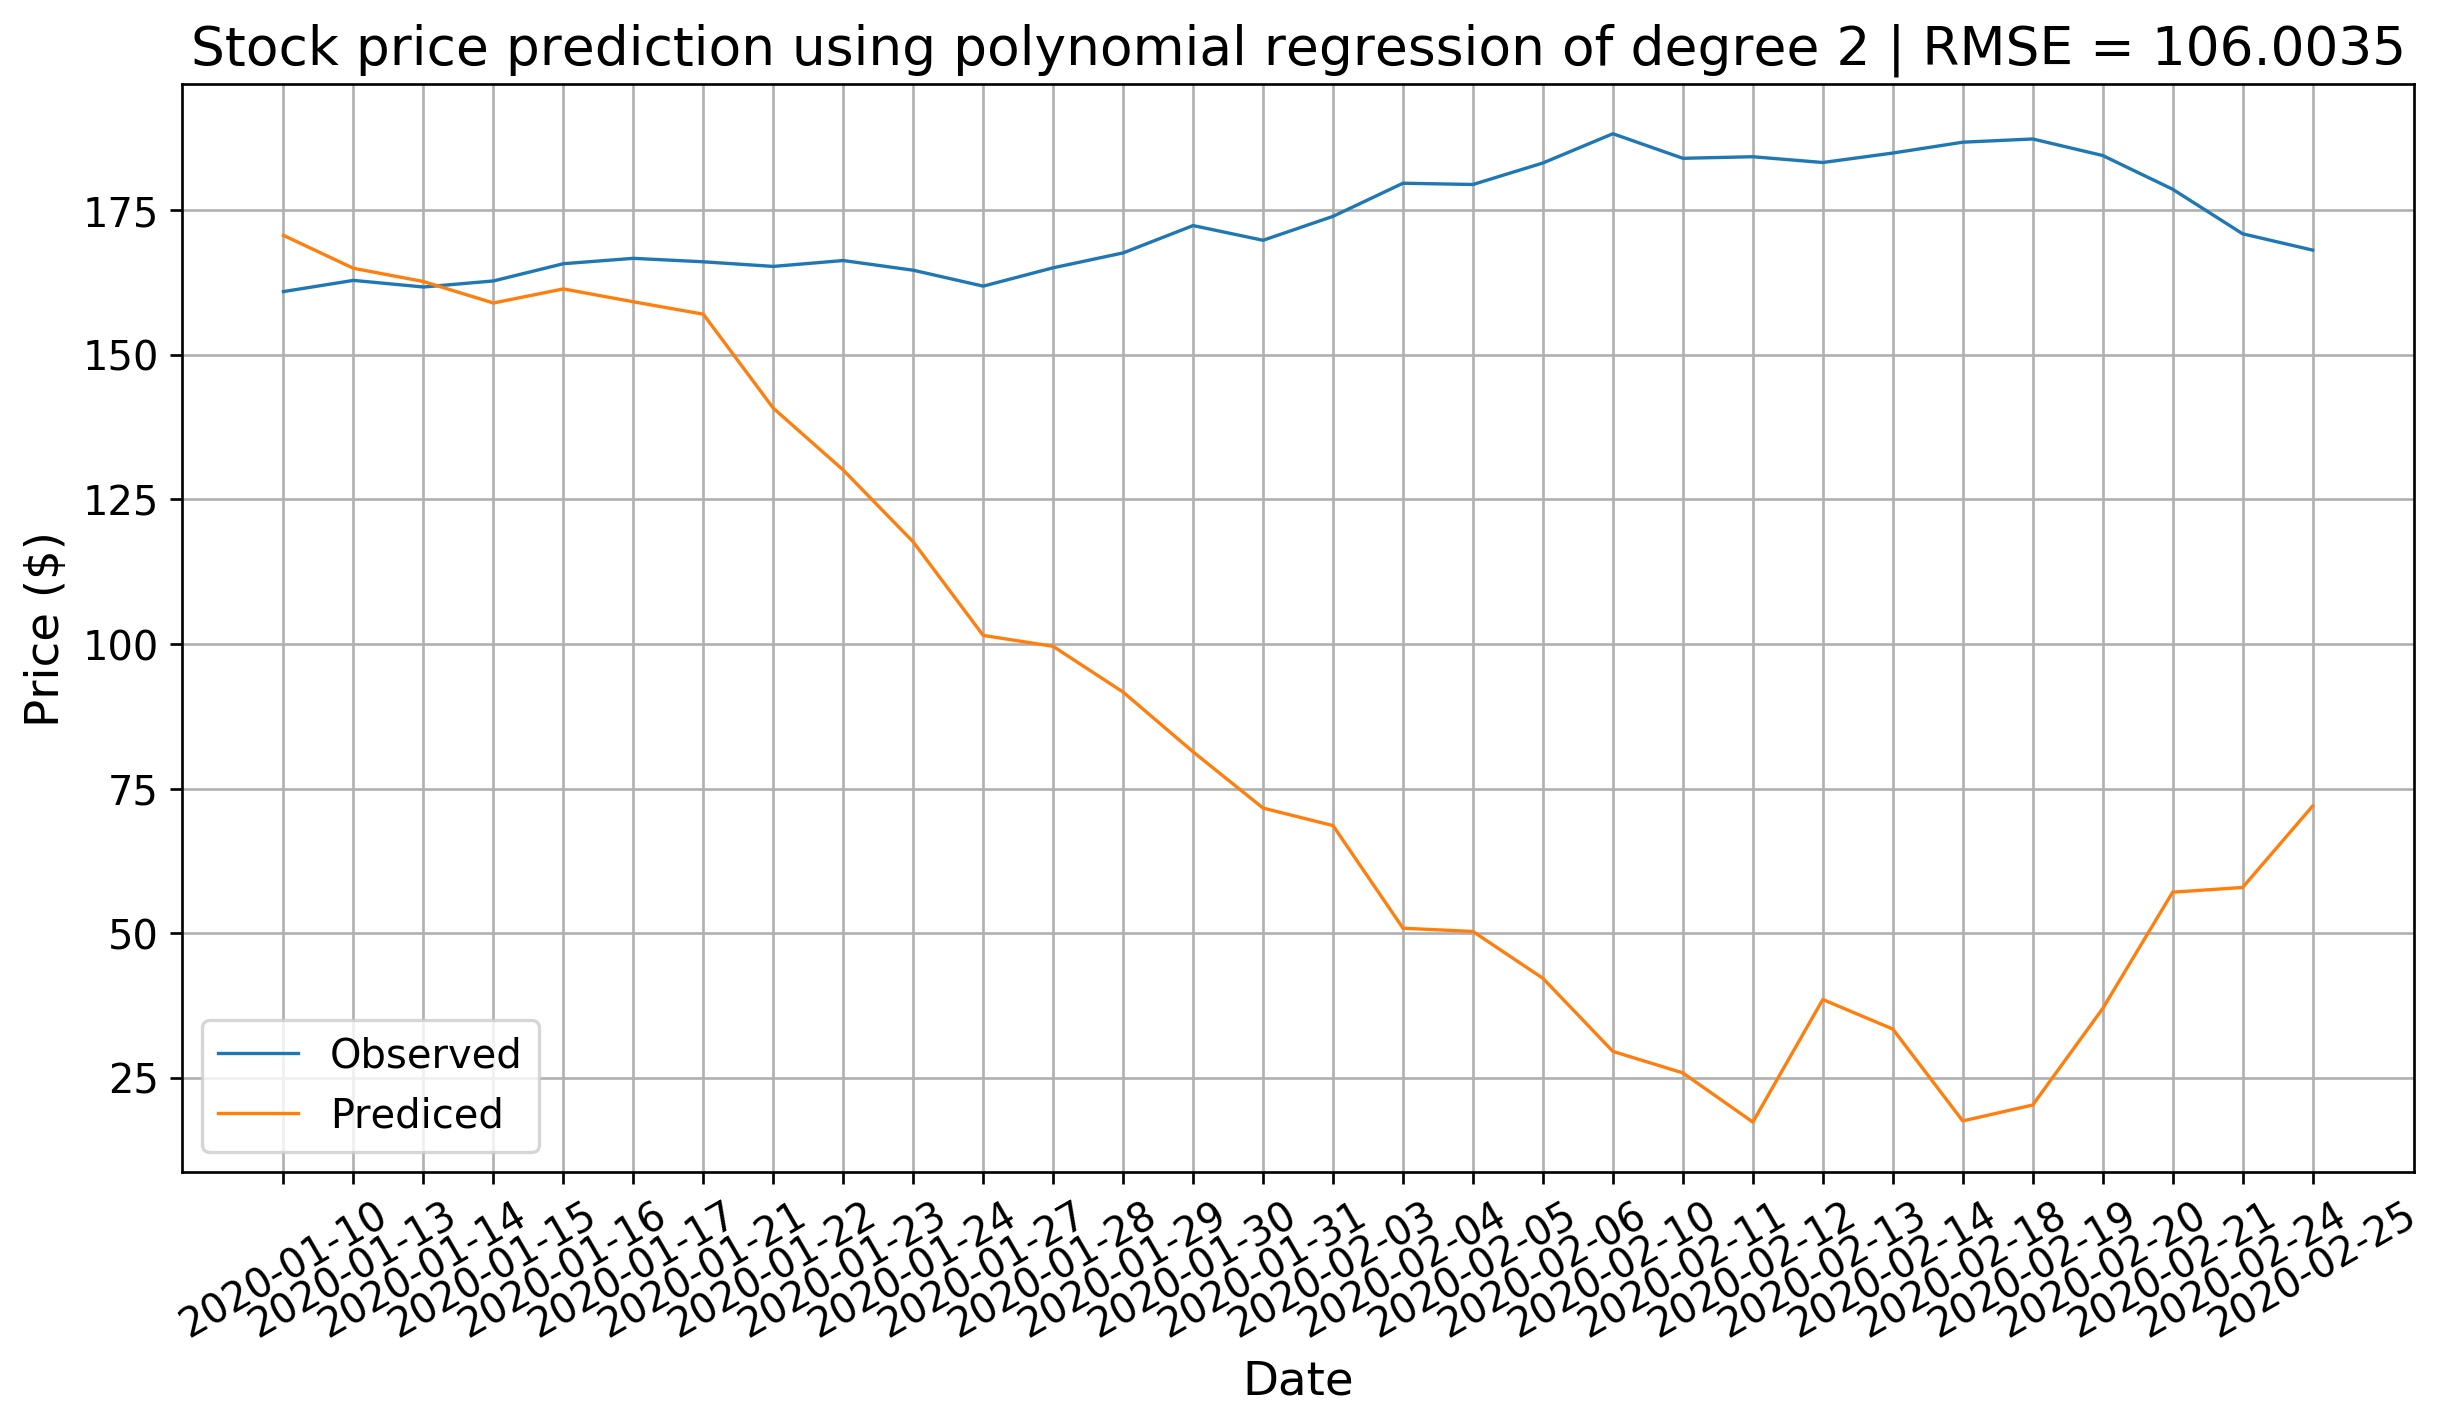

In [3]:
# Create plot

plt.plot(y_test.index, y_test.values, label = 'Observed')

plt.plot(y_test.index, y_pred, label = 'Prediced')

plt.legend(loc = 'best')
plt.title('Stock price prediction using polynomial regression of degree ' +
          str(d) + ' | RMSE = ' + str(round(rmse, 4)))
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=30)

plt.savefig('plots/polynomial_regression.pdf', dpi=300)

# plt.show()

In [4]:
########################
##### PREDICT THE FUTURE
########################

# Create the training set used to predict the future

f_train = data.iloc[:pred_period, :].sort_index()

# Transform data

f_train_trans = PolynomialFeatures(degree=d, include_bias=False).fit_transform(f_train)

# Predict the future

f_pred = poly.predict(f_train_trans)

# Create future dates

last_date = datetime.datetime.strptime(f_train.index[-1], '%Y-%m-%d').date()

f_dates = [last_date + datetime.timedelta(days=x + 1) for x in range(len(f_pred))]

# Convert future datetimes to string

f_dates = [d.strftime('%Y-%m-%d') for d in f_dates]

# Store future forecasts in a dataframe

forecast_lm = pd.DataFrame(list(zip(f_dates, f_pred)), columns=['date', 'price'], index=f_dates)

# Set the time period (prior to future forecasting) to plot

timeframe = 45

data_tmp = data.iloc[:timeframe, :]

actual = pd.DataFrame(list(zip(list(data_tmp.index), list(data_tmp[target]))),
                      columns=['date', 'price'],
                      index=[datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in list(data_tmp.index)])

actual.sort_index(ascending=True, inplace=True)

del data_tmp

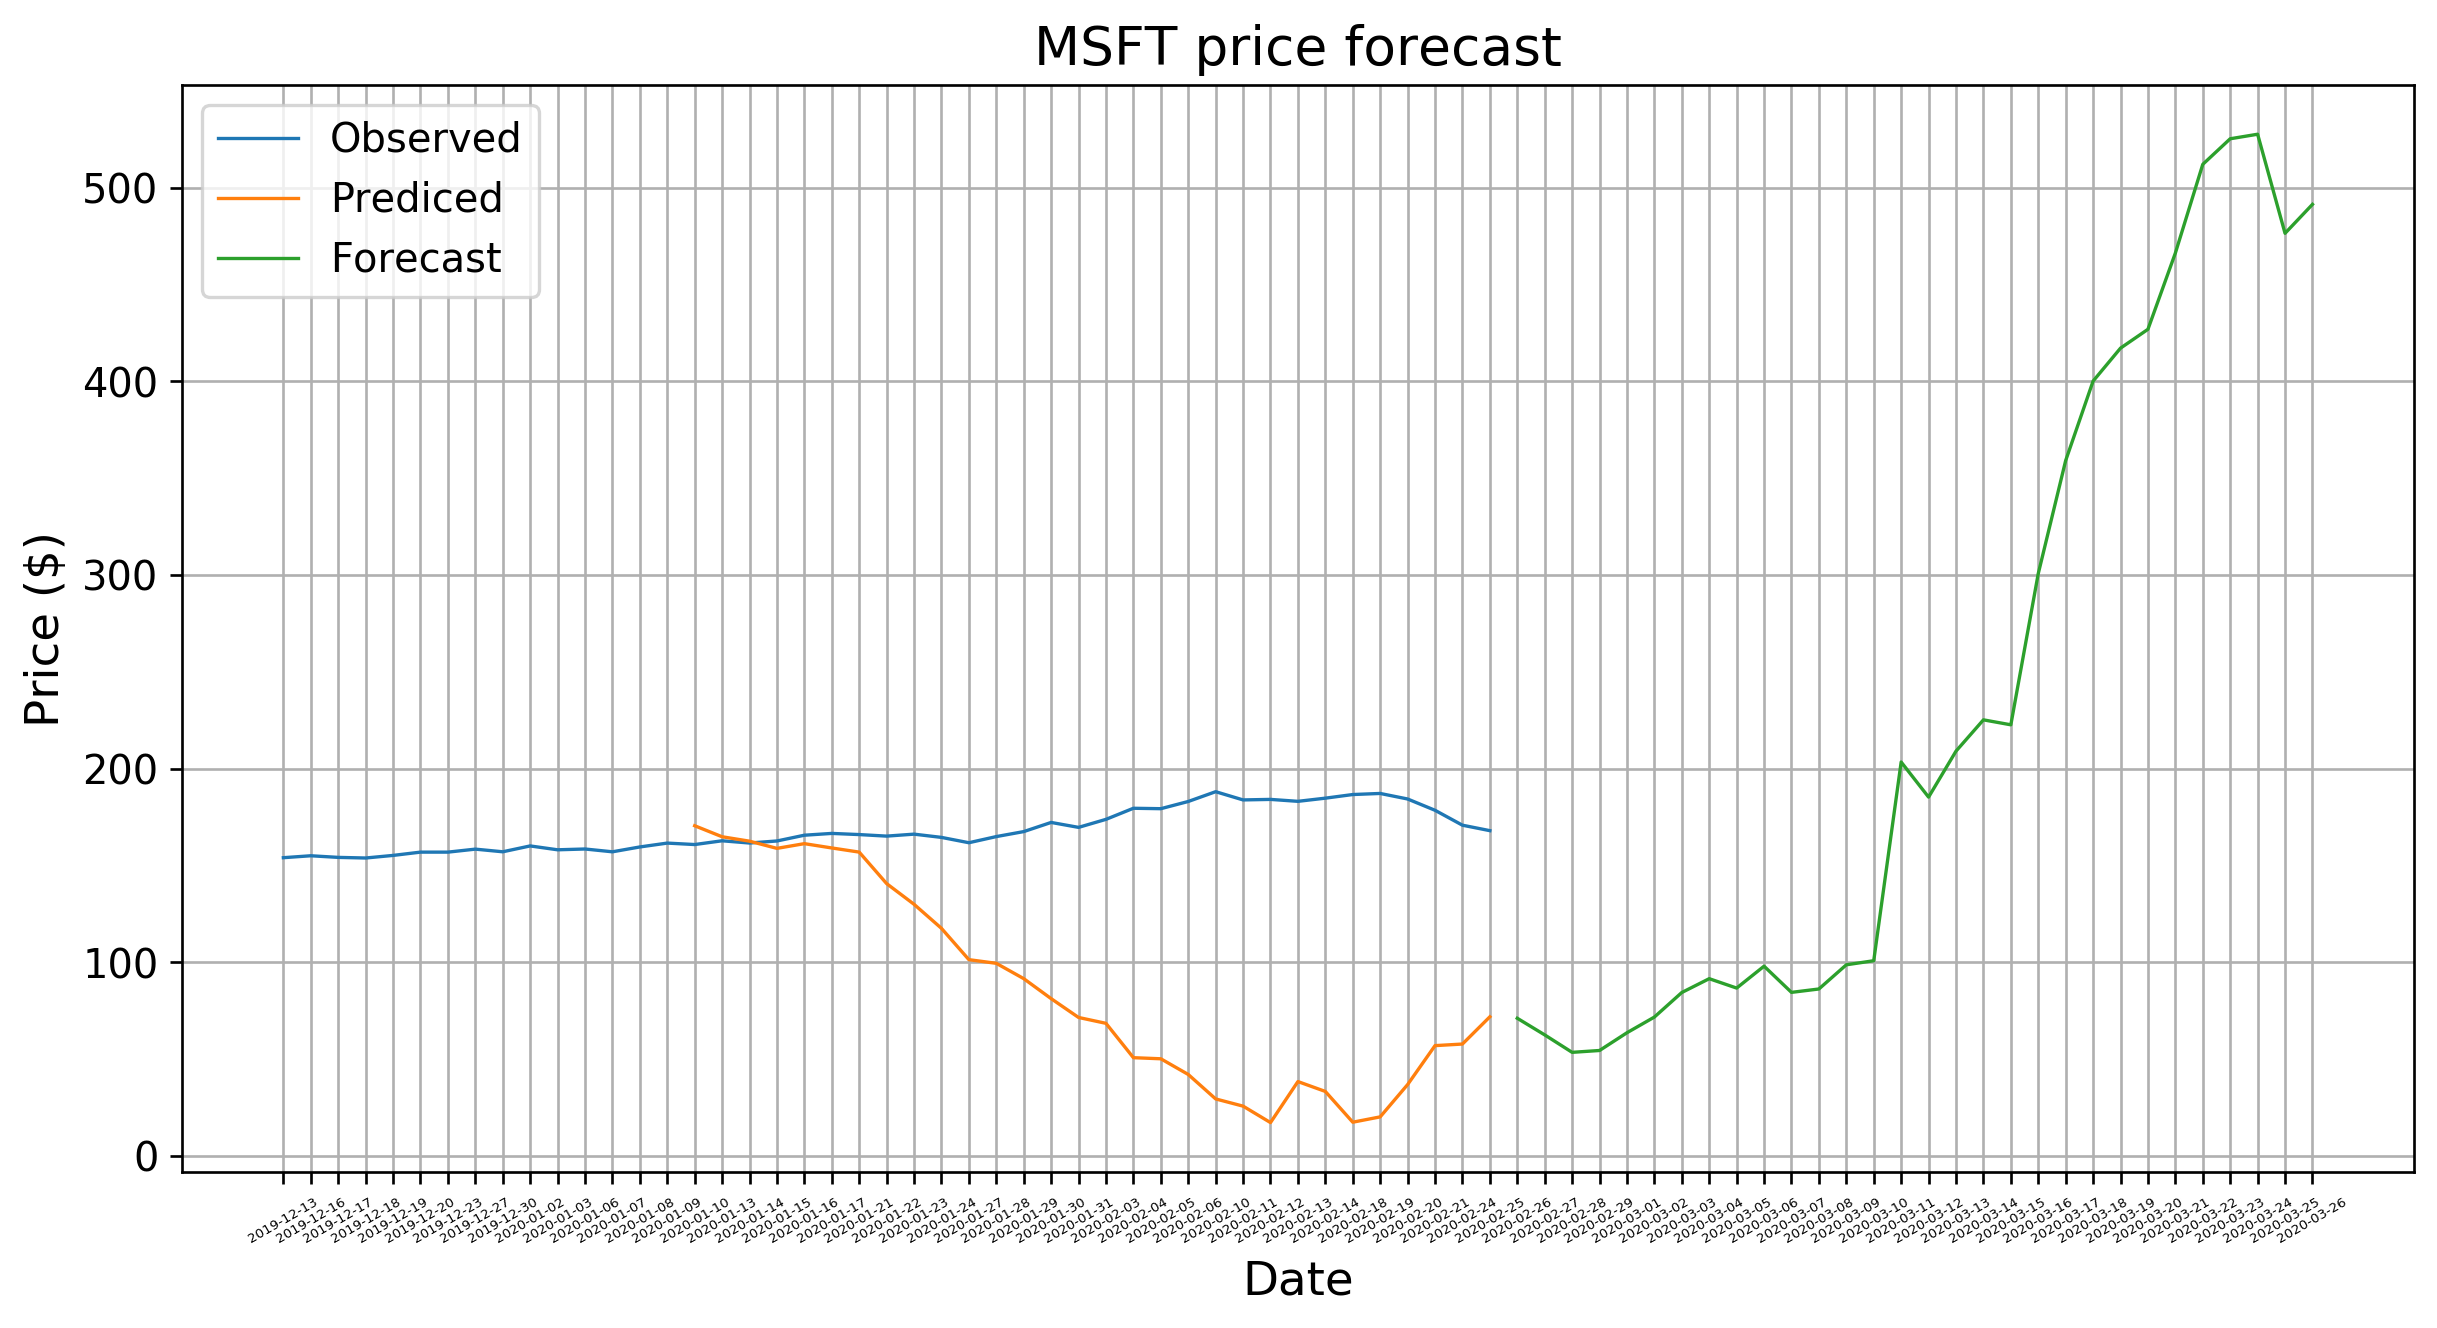

In [5]:
# Create plot

plt.plot(actual['date'], actual['price'], label = 'Observed')

plt.plot(y_test.index, y_pred, label = 'Prediced')

plt.plot(forecast_lm['date'], forecast_lm['price'], label = 'Forecast')

plt.legend(loc = 'best')
plt.title(target_stock + ' price forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=30, fontsize=4)

plt.savefig('plots/polynomial_regression_forecast.pdf', dpi=300)

# plt.show()